# Calculating time scales for *cis/trans* isomerization


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

### Load in the omega angle trajectories by replica

In [14]:

residues_to_plot = [0]
num_residues = len(residues_to_plot)

omegas_by_replica = []
save_dir = 'omega_data'
all_omega=Data.load(f"{save_dir}/data.pkl").array_list # This is an (716, x, 3) array


for i, individual_omega in enumerate(all_omega):
    nsnaps, res = individual_omega.shape
    #print(individual_omega.shape)
    shifted_omega = (individual_omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    plt.figure(figsize=(10, 2))
    start = 0
    
    for panel, residue in enumerate(residues_to_plot, 1):
        plt.subplot(len(residues_to_plot), 1, panel)
        t = np.arange(start, nsnaps) * 0.010  # Time axis in ns
        plt.plot(t, omegas_by_replica[i][start:nsnaps, residue], '.', ms=1)
        plt.xlabel('time (ns)')
        plt.ylabel(f'$\\omega$ res {residue} (deg)')
        plt.title(f'Omega angles vs Time for residue {residue} (replica {i}) in 19AE1-4-A')
    plt.tight_layout()
plt.show()




In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
residues_to_plot = [0, 1, 2]  # Residues to plot
num_residues = len(residues_to_plot)

omegas_by_replica = []  # To store processed omega data
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/data.pkl").array_list  # This is an (716, x, 3) array

# Process and store shifted omega data
for i, individual_omega in enumerate(all_omega):
    # Compute shifted omega to avoid periodic boundaries
    shifted_omega = (individual_omega + 90.0) % 360.0 - 90.0
    omegas_by_replica.append(shifted_omega)  # Store in list

# Plot omega angles for the selected residues
for i, shifted_omega in enumerate(omegas_by_replica):
    nsnaps, res = shifted_omega.shape  # Get number of snapshots and residues

    plt.figure(figsize=(10, 2))  # Create a figure for each replica
    start = 0

    # Plot each residue
    for panel, residue in enumerate(residues_to_plot, 1):
        plt.subplot(len(residues_to_plot), 1, panel)
        t = np.arange(start, nsnaps) * 0.010  # Time axis in ns
        plt.plot(t, shifted_omega[start:nsnaps, residue], '.', ms=1)
        plt.xlabel('time (ns)')
        plt.ylabel(f'$\\omega$ res {residue} (deg)')
        plt.title(f'Omega angles vs Time for residue {residue} (replica {i}) in 19AE1-4-A')

    plt.tight_layout()  # Adjust layout
    plt.show()


## Convert the omega angle trajectories to cis(0)/trans(1) trajectories 

In [25]:
cistrans_by_replica = []

for i, individual_omega in enumerate(all_omega):
    nsnaps, res = individual_omega.shape
    #print(individual_omega.shape)
    shifted_omega = (individual_omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    cistrans_by_replica.append(cistrans)
    
print(cistrans_by_replica)


[array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1]]), array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1]]), array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       ...,
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]]), array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 1, 1],
       [1, 1, 1],
       [1, 1, 1]]), array([[0, 1, 1],
       [0, 1, 1],
       [0, 1, 1],
       ...,
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1]]), array([[1, 1, 0],
       [1, 1, 0],
       [1, 1, 0],
       ...,
       [1, 1, 0],
       [1, 1, 0],
       [1, 1, 0]]), array([[1, 1, 0],
       [1, 1, 0],
       [1, 1, 0],
       ...,
       [1, 1, 0],
       [1, 1, 0],
       [1, 1, 0]]), array([[0, 1, 1],
       [0, 1, 1],
       [0, 1, 1],
       ...,
       [0, 1, 1],
       [0, 1, 1],
       [0, 1, 1]]), array([[1, 0, 1],
     

#### compile transition probabilities as a function of lag time (in steps)

In [26]:
def get_transition_matrix(cistrans_traj, lagtime=10, sliding_window=True, pseudocount=0.25):
    """Returns a row-normalized transiton matrix T for a given lagtime (in steps)."""

    C = np.zeros( (2,2) )   # count matrix
    T = np.zeros( (2,2) )   # transition matrix
    
    N = len(cistrans_traj)  # the length of the trajectory
    for t in range(0, N-lagtime):
        C[cistrans_traj[t],cistrans_traj[t+lagtime]] += 1.0

    # add pseudocounts to avoid zero entries
    C += pseudocount    
    
    # row-normalize
    T[0,:] = C[0,:]/C[0,:].sum()
    T[1,:] = C[1,:]/C[1,:].sum()

    return T

def implied_timesale(T, lagtime=1):
    """Return the implied timescale, in units of number of steps.
    
    INPUT
    T       - transition matrix where T_ij is prob of transitioning i -> j in lagtime.
    
    PARAMETERS
    lagtime - lagtime used to build T (in units of steps). Default = 1
    
    RETURN
    t2      - the implied timescale (in units of steps)
    """
    try:
        evals = np.linalg.eigvals( T.transpose() )  # will be something like [0.99754545 1.        ]
        mu2 = min(evals) # non-stational eigenvalue of T
        # print('mu2', mu2, 'evals', evals, 'T', T)
        t2 = -1.0*lagtime/np.log(mu2)  # the implied timescale relation
    except:
        t2 = np.nan
        
    return t2
    

## Let's make an implied timescale plot for each omega angle

lagtimes = [1, 10, 25, 50, 100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 10100, 11100, 12100, 13100, 14100, 15100, 16100, 17100, 18100, 19100, 20100, 21100, 22100, 23100, 24100, 25100, 26100, 27100, 28100, 29100, 30100, 31100, 32100, 33100, 34100, 35100, 36100, 37100, 38100, 39100]


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_7585/3359252332.py:36: RuntimeWarning: invalid value encountered in log
  t2 = -1.0*lagtime/np.log(mu2)  # the implied timescale relation


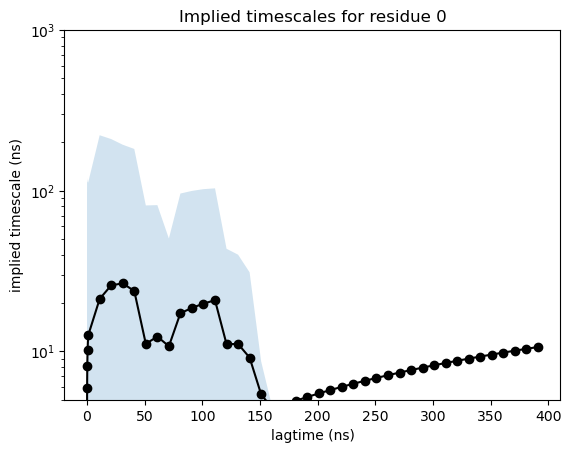

lagtimes = [1, 10, 25, 50, 100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 10100, 11100, 12100, 13100, 14100, 15100, 16100, 17100, 18100, 19100, 20100, 21100, 22100, 23100, 24100, 25100, 26100, 27100, 28100, 29100, 30100, 31100, 32100, 33100, 34100, 35100, 36100, 37100, 38100, 39100]


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_7585/3359252332.py:36: RuntimeWarning: invalid value encountered in log
  t2 = -1.0*lagtime/np.log(mu2)  # the implied timescale relation


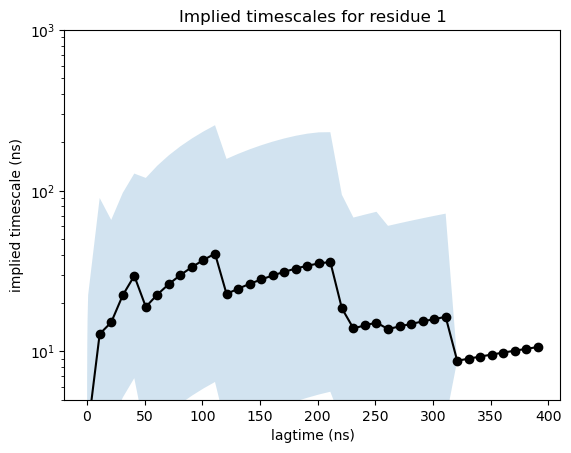

lagtimes = [1, 10, 25, 50, 100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 10100, 11100, 12100, 13100, 14100, 15100, 16100, 17100, 18100, 19100, 20100, 21100, 22100, 23100, 24100, 25100, 26100, 27100, 28100, 29100, 30100, 31100, 32100, 33100, 34100, 35100, 36100, 37100, 38100, 39100]


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_7585/3359252332.py:36: RuntimeWarning: invalid value encountered in log
  t2 = -1.0*lagtime/np.log(mu2)  # the implied timescale relation


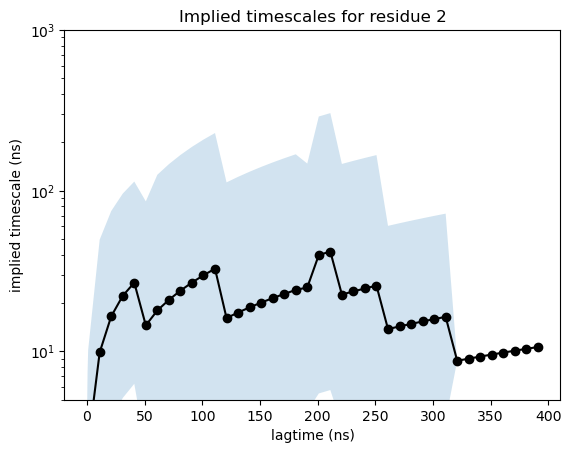

In [27]:
residues = [0,1,2]
for residue in residues:
    
    lagtimes = [1, 10, 25, 50] + list(range(100, 40000, 1000))
    print('lagtimes =', lagtimes)
    
    t2_means = []  # mean timescales for each lagtime
    t2_uppers  = []  # upperlim of standard deviation of log t2 for each lagtime
    t2_lowers  = []  # lowerlim
    
    for lagtime in lagtimes:
    
        # Each replica is a separate data set we can use for uncertainty estimation
        logt2_values = []    
        for i in range(nreplicas):
            T = get_transition_matrix(cistrans_by_replica[i][:,residue], lagtime=lagtime)
            logt2_values.append(np.log(implied_timesale(T, lagtime=lagtime)))
        logt2_values = np.array(logt2_values)    
        Ind = ~np.isnan(logt2_values)
        t2_means.append( np.exp(np.mean(logt2_values[Ind] ) ))
        t2_uppers.append( np.exp( np.mean(logt2_values[Ind] ) + np.std(logt2_values[Ind]) ))
        t2_lowers.append( np.exp( np.mean(logt2_values[Ind] ) - np.std(logt2_values[Ind]) ))
    
    t2_means = np.array(t2_means)
    t2_uppers = np.array(t2_uppers)
    t2_lowers = np.array(t2_lowers)
    lagtimes  = np.array(lagtimes)
    
    plt.figure()
    plt.plot(lagtimes*dt_in_ns, t2_means*dt_in_ns, 'ko-')
    plt.fill_between(lagtimes*dt_in_ns, t2_uppers*dt_in_ns, t2_lowers*dt_in_ns, alpha=0.2)
    plt.xlabel('lagtime (ns)')
    plt.ylabel('implied timescale (ns)')
    plt.ylim(5,1000)
    plt.yscale('log')
    plt.title(f'Implied timescales for residue {residue}')
    plt.show()
    

In [15]:
def autocorr(x):
    tau = x.size
    mu = x.mean()
    var = x.var()  # Variance for normalization
    g = np.correlate((x-mu), (x-mu), mode='full')[tau-1:]
    g = g / var
    n = np.arange(tau,0,-1)
    return g/n

(6, 3, 80004)


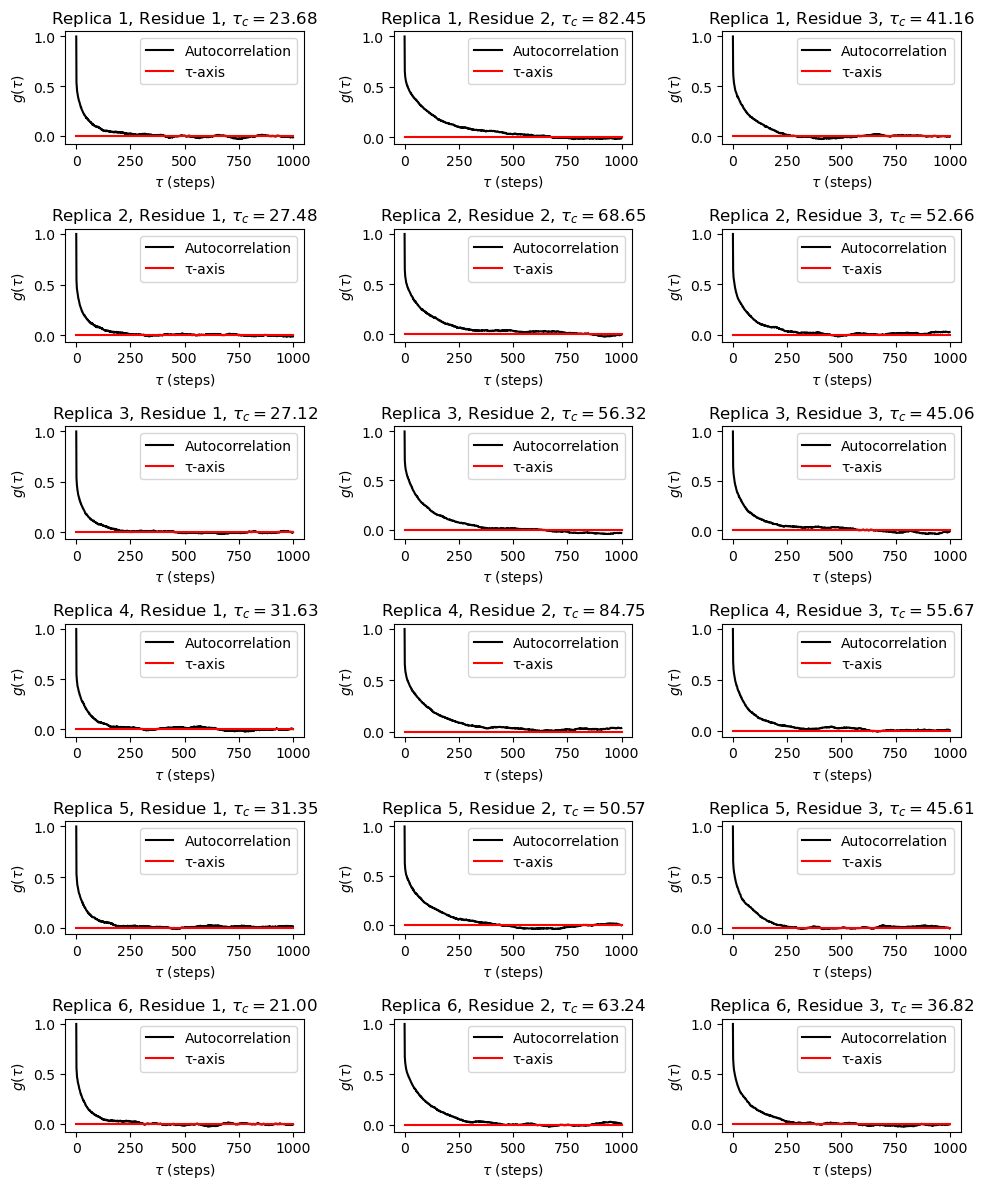

In [30]:
# Load in the omega angles by replica
dt_in_ns = 0.010   # 10 ps per snapshot
nreplicas = 6
Nmax = 1000  # Maximum number of steps to display in plots


# Convert list of lists to a NumPy array
omegas_by_replica = np.array(omegas_by_replica)

nreplicas, timesteps, residues = omegas_by_replica.shape

# Calculate autocorrelation for each replica and residue
autocorr_results = np.zeros((nreplicas, residues, timesteps))


for i in range(nreplicas):
    for j in range(residues):
        omega_angles = omegas_by_replica[i, :, j]
        autocorr_results[i, j, :] = autocorr(omega_angles)

print(autocorr_results.shape)  # Should output (6, 3, 80004)

fig, axes = plt.subplots(nreplicas, residues, figsize=(10, 2 * nreplicas))
axes = np.atleast_2d(axes)  # Ensure axes is always 2D for consistent indexing

for i in range(nreplicas):
    for j in range(residues):
        ax = axes[i, j]
        g = autocorr_results[i, j, :]
        tau_c = np.sum(g[0:Nmax])
        
        ax.plot(np.arange(Nmax), g[:Nmax], 'k-', label='Autocorrelation')  # Plot the autocorrelation
        ax.plot([0, Nmax], [0, 0], 'r-', label='τ-axis')  # Red horizontal line at zero
        
        ax.set_xlabel('$\\tau$ (steps)')
        ax.set_ylabel('$g(\\tau)$')
        ax.set_title(f'Replica {i+1}, Residue {j+1}, $\\tau_c = {tau_c:.2f}$')  # Display tau_c in title
        ax.legend()

plt.tight_layout()
plt.show()


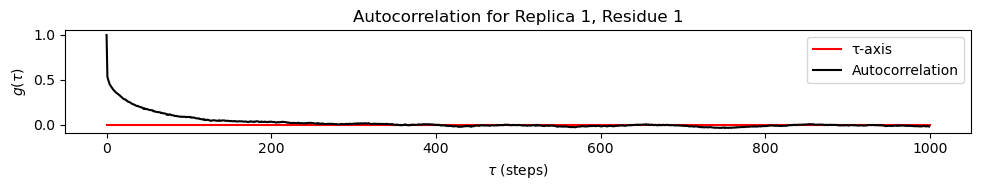

Estimated tau_c = 23.682813847874456


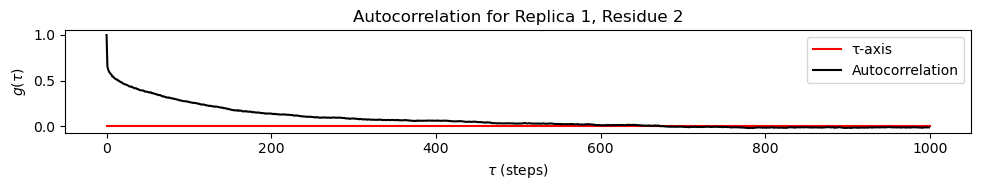

Estimated tau_c = 82.454382076889


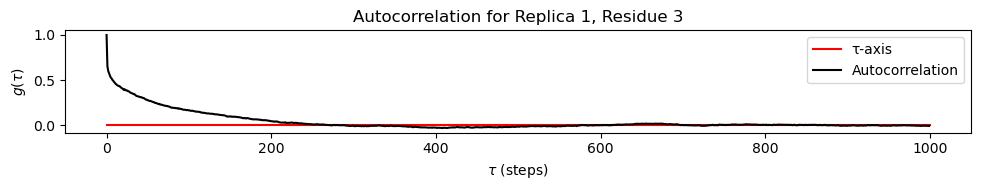

Estimated tau_c = 41.15588315118355


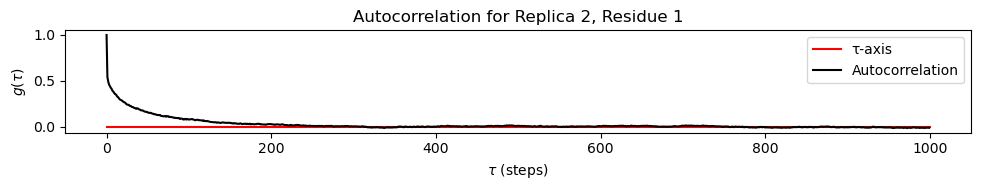

Estimated tau_c = 27.476858804140843


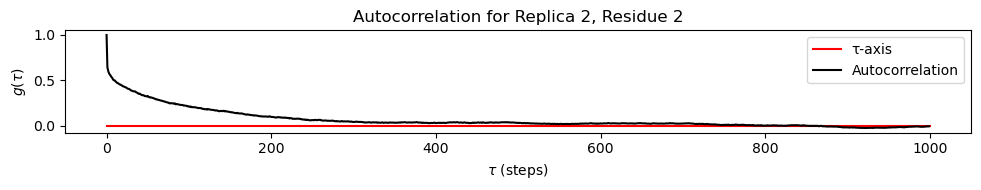

Estimated tau_c = 68.6541091202039


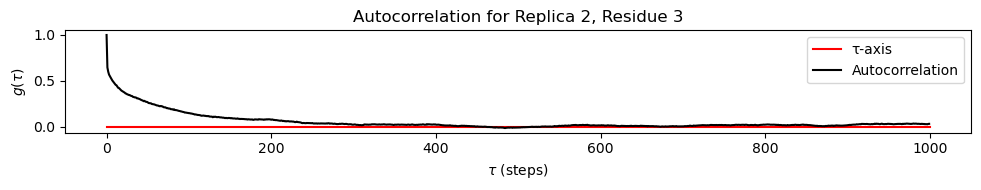

Estimated tau_c = 52.66302655734175


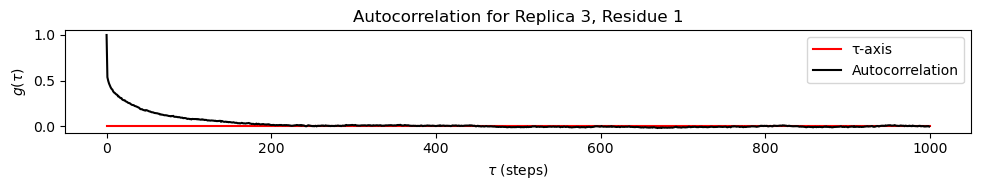

Estimated tau_c = 27.11827809608424


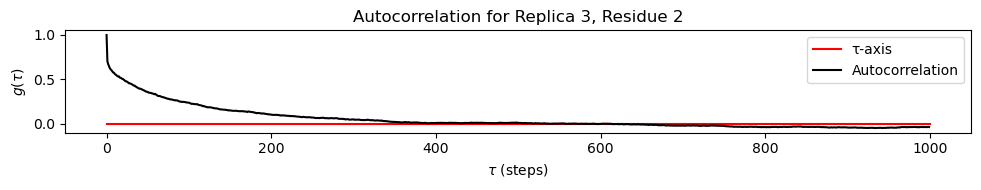

Estimated tau_c = 56.31754244414188


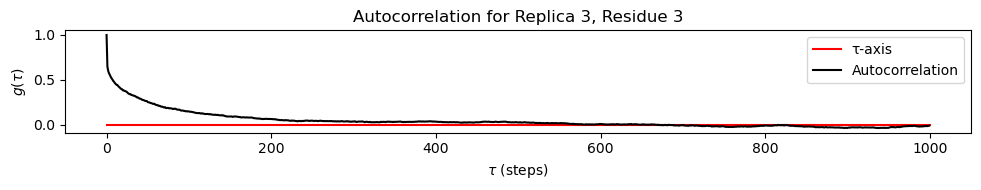

Estimated tau_c = 45.06298829824072


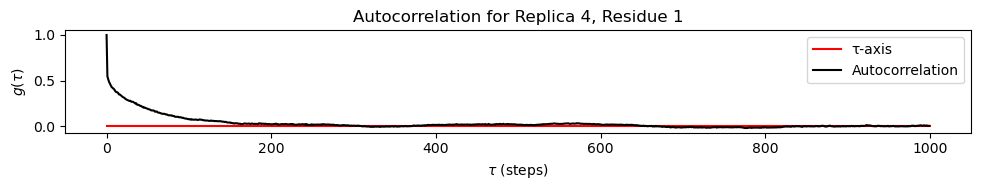

Estimated tau_c = 31.626873964837678


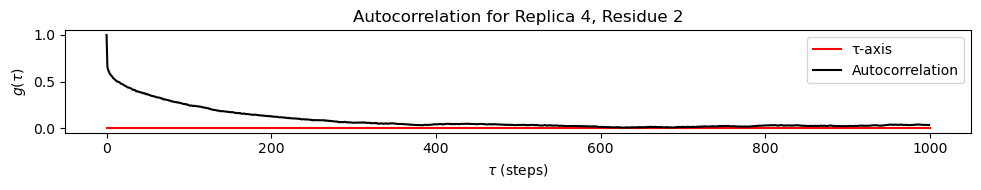

Estimated tau_c = 84.74694874578296


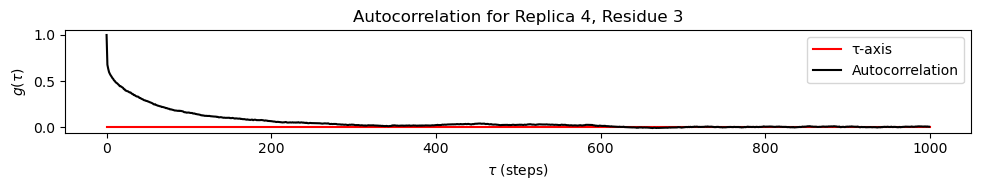

Estimated tau_c = 55.668739764075184


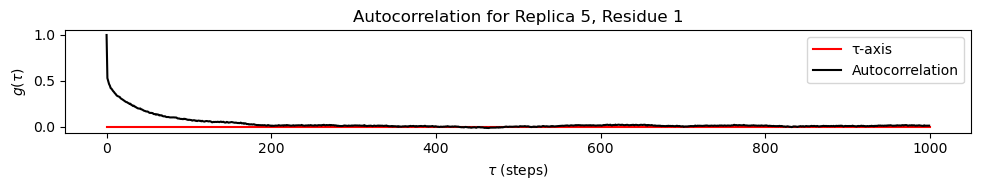

Estimated tau_c = 31.34566664405027


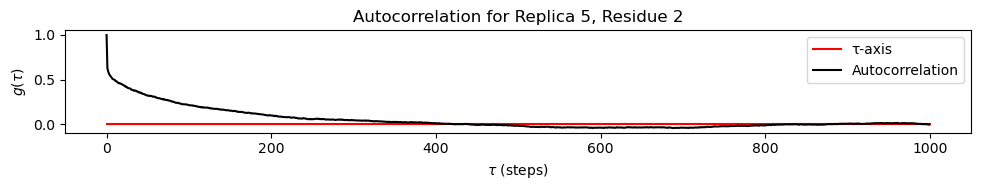

Estimated tau_c = 50.57145810090983


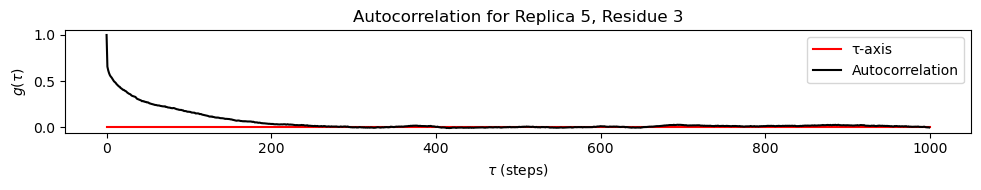

Estimated tau_c = 45.614418306065666


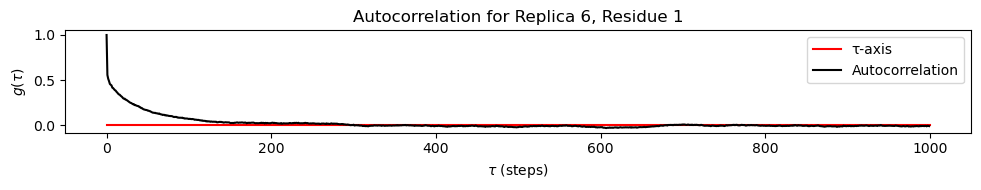

Estimated tau_c = 21.003750214444022


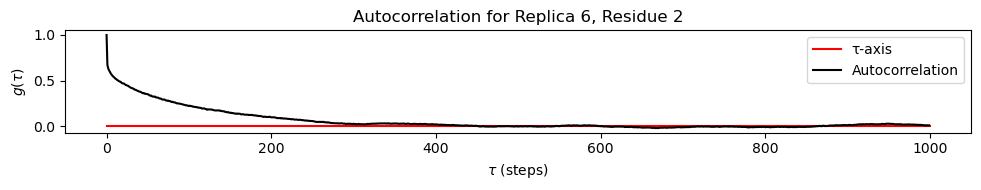

Estimated tau_c = 63.2373870520981


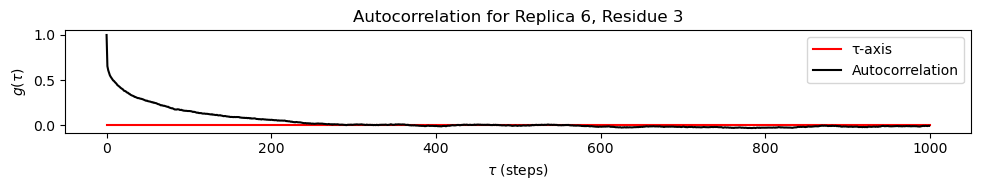

Estimated tau_c = 36.81544934312683


In [28]:
# Create separate plots for each replica and residue
for i in range(nreplicas):
    for j in range(residues):
        g = autocorr_results[i, j, :]

        # Create a new figure for each replica and residue combination
        plt.figure(figsize=(10, 2))
        plt.plot([0, Nmax], [0, 0], 'r-', label='τ-axis')  # Red horizontal line at zero
        plt.plot(np.arange(Nmax), g[:Nmax], 'k-', label='Autocorrelation')
        plt.xlabel('$\\tau$ (steps)')
        plt.ylabel('$g(\\tau)$')
        plt.title(f'Autocorrelation for Replica {i+1}, Residue {j+1}')
        plt.legend()
        plt.tight_layout()
        plt.show()

        tau_c = np.sum(g[0:Nmax])
        print('Estimated tau_c =', tau_c)